In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functools import partial
from multiprocessing import shared_memory
from multiprocessing.dummy import Pool
from sklearn.ensemble import RandomForestRegressor
import multiprocessing as mp
from itertools import chain, combinations
import sys
import os
from scipy import stats

from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor

import mp_run

import concurrent.futures
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# styling:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['ggplot'])
sns.set_palette("deep")

In [2]:
perturbation_factor = 3
num_rf_predictors = 500

target_tf = 'AT2G46680'

induction_flag = -1
mp_threads = 20
# if (len(sys.argv)>=3):
#     induction_flag = bool(sys.argv[1])
#     mp_threads = int(sys.argv[2])

In [3]:
tf_df = pd.read_csv('data/wrky_regulators.csv')
tf_list = tf_df['Gene']

In [4]:
def choose_2_3(iterable):
    "powerset([1,2,3]) -->  (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(2,4))

In [5]:
target_df = pd.read_csv('data/wrky_targets_neg.csv')
if (induction_flag > 0):
    target_df = pd.read_csv('data/wrky_targets_pos.csv')
deg_genes = target_df['Gene']

In [6]:
ts_df = pd.read_csv('data/GSE97500/expression.tsv', sep='\t', index_col=0)
c = pd.Series(list(set(deg_genes).intersection(set(ts_df.index))))
tf_list = pd.Series(list(set(tf_list).intersection(set(ts_df.index))))
meta_df = pd.read_csv('data/GSE97500/meta_data.tsv', sep='\t')
ts_exp_index = meta_df[meta_df['isTs']]
ts_exp_index_target =  ts_exp_index[ts_exp_index['is1stLast'] != 'f'].condName
ts_exp_index_source =  ts_exp_index[ts_exp_index['is1stLast'] != 'f'].prevCol

In [7]:
target_genes = set(deg_genes).intersection(set(ts_df.index))

In [8]:
non_trivial_targets = []
for target in target_genes:
    if ts_df.loc[target].mean() != 0.0:
        non_trivial_targets.append(target)


In [9]:
target_genes = pd.Series(non_trivial_targets)

In [12]:

ts_train_y_list = ts_df[ts_exp_index_target]

result_list = []
result_measure_list = []

p_val_res_list = []

for target_gene in tqdm(target_genes):
    # train_gene_index = tf_list[tf_list != target_gene]
    train_gene_index = tf_list
    
    ts_train_X = ts_df[ts_exp_index_source].T[train_gene_index]

    ts_train_y = ts_train_y_list.loc[target_gene]

    input_mean = ts_train_X.mean()
    input_std = ts_train_X.std()
    # two set of perturbations:
    # one with each WRKY and HB7 perturbed at the same time
    # another, i.e., the alt one with just each WRKY perturbed
    perturbation_input = input_mean.copy()
    perturbation_input_alt = input_mean.copy()
    perturbation_input[target_tf] += input_std[target_tf]*perturbation_factor
    perturbation_input = np.tile(perturbation_input.values, (len(input_mean),1))
    perturbation_input_alt = np.tile(perturbation_input_alt.values, (len(input_mean),1))
    for i, tf_name in enumerate(tf_list):
        if tf_name == target_tf: continue
        perturbation_input[i][i] += input_std[tf_name]*perturbation_factor
        perturbation_input_alt[i][i] += input_std[tf_name]*perturbation_factor
    func = partial(mp_run.rf_feature_importance, ts_train_X, ts_train_y, perturbation_input, perturbation_input_alt)

    with mp.Pool() as pool:
        results = pool.map(func, range(num_rf_predictors))
    results = np.array(results)
    target_tf_index = np.where(tf_list == target_tf)[0][0]
    p_val_list = []
    for i, tf_name in enumerate(tf_list):
        if i == target_tf_index: 
            t_val, p_val = stats.ttest_rel(results[:, 0, target_tf_index], np.zeros(num_rf_predictors))
        else:
            t_val, p_val = stats.ttest_rel(results[:, 0, i], results[:, 0, target_tf_index] + results[:, 1, i])
        if (induction_flag*t_val > 0): p_val_list.append(p_val)
        else: p_val_list.append(1)
    p_val_res_list.append(p_val_list)
    break

# tf_df.index = tf_df['Gene']
# out_df = pd.DataFrame(index=target_genes, columns=tf_df.loc[tf_list]['Symbol'], data=np.array(p_val_res_list))

# out_df.to_csv('./output/rf_wrky_inf_pval_neg.csv')

  0%|          | 0/639 [00:05<?, ?it/s]


In [ ]:
tf_df.index = tf_df['Gene']
out_df = pd.DataFrame(index=target_genes, columns=tf_df.loc[tf_list]['Symbol'], data=np.array(p_val_res_list))

In [ ]:
out_df.to_csv('./output/xb_wrky_inf_pval_neg.csv')

In [ ]:
tf_df.index = tf_df['Gene']
tf_df.loc[tf_list]['Symbol']

In [ ]:
out_df

In [ ]:

regr = RandomForestRegressor(random_state=0)

ts_train_y_list = ts_df[ts_exp_index_target]

result_list = []
result_measure_list = []

for target_gene in tqdm(target_genes):
    train_gene_index = tf_list[tf_list != target_gene]
    ts_train_X = ts_df[ts_exp_index_source].T[train_gene_index]

    ts_train_y = ts_train_y_list.loc[target_gene]

    input_mean = ts_train_X.mean()
    input_std = ts_train_X.std()
    perturbation_input = input_mean.copy()
    perturbation_input = np.repeat(np.array(input_mean), repeats=len(input_mean), axis=0)
    perturbation_input = perturbation_input.reshape(len(input_mean),len(input_mean)) + np.diagflat(np.array([ts_train_X.values.std()]*len(input_mean)) * perturbation_factor)

    func = partial(mp_run.rf_feature_importance, ts_train_X, ts_train_y)

    with mp.Pool() as pool:
        results = pool.map(func, range(num_rf_predictors))


    base_predictions = [result.predict(np.array(input_mean).reshape(1,-1))[0] for result in results]
    y_std = ts_train_y.std()

    perturbation_input_list = np.array_split(perturbation_input, 10)
    perturbation_input_shapes = [p.shape for p in perturbation_input_list]
    shared_memory_list = []
    for i, p in enumerate(perturbation_input_list):
        shm = shared_memory.SharedMemory(create=True, size=p.nbytes, name="perturbation_input_"+str(i))
        buffer = np.ndarray(p.shape, dtype=p.dtype, buffer=shm.buf)
        buffer[:] = p[:]
        shared_memory_list.append(shm)


    def f(perturbation_input_shapes, x):
        pred_list = []
        for i, shape in enumerate(perturbation_input_shapes):

            # Attach to the existing shared memory
            existing_shm = shared_memory.SharedMemory(name='perturbation_input_'+str(i))
            # Read from the shared memory (we know the size is 1)
            c = np.ndarray(shape, dtype=np.float64, buffer=existing_shm.buf)
            pred_list.append(x.predict(c))
            existing_shm.close()
        return np.concatenate(pred_list)

    func = partial(f, perturbation_input_shapes)

    with mp.Pool(processes=mp_threads) as pool:
        perturbation_predictions = pool.map(func, results)

    for shm in shared_memory_list:
        shm.close()
        shm.unlink()


    perturbation_measures = [(perturbation_prediction - base_prediction)/y_std for perturbation_prediction, base_prediction in zip(perturbation_predictions, base_predictions)]
    importance_matrix = np.array(perturbation_measures).T
    importance_df = pd.DataFrame(index=train_gene_index, data=importance_matrix, columns=range(num_rf_predictors))
    importance_df_list = []
    mean_importance = importance_df.mean(axis=1)
    if (induction_flag):
        top_influence_genes = train_gene_index[np.argsort(mean_importance)[::-1][:5]]
    else:
        top_influence_genes = train_gene_index[np.argsort(mean_importance)[:5]]
    importance_df_list.append(mean_importance)
    data_mean = ts_df.T[top_influence_genes].mean()
    data_std = ts_df.T[top_influence_genes].std()
    regr = RandomForestRegressor(random_state=42, warm_start=True, n_estimators=100, n_jobs=20)
    ts_train_X = ts_df[ts_exp_index_source].T[top_influence_genes]
    regr = regr.fit(ts_train_X, ts_train_y)

    base_prediction = regr.predict(np.array(data_mean).reshape(1,-1))[0]
    y_std = ts_df.T.std()[target_gene]
    perturbation_list = list(choose_2_3(top_influence_genes))

    perturbation_result_list = []
    perturbation_list_names = ['; '.join(perturbation_genes) for perturbation_genes in perturbation_list]
    for perturbation_genes in perturbation_list:
        perturbation_input = data_mean.copy()
        for gene in perturbation_genes:
            perturbation_input[gene] += data_std[gene] * perturbation_factor
        perturbation_prediction = regr.predict(np.array(perturbation_input).reshape(1,-1))[0]
        perturbation_measure = (perturbation_prediction - base_prediction)/y_std
        perturbation_result_list.append(perturbation_measure)
    if (induction_flag):
        result_list.append(np.array(perturbation_list_names)[np.argsort(perturbation_result_list)[::-1][:5]])
        result_measure_list.append(np.array(perturbation_result_list)[np.argsort(perturbation_result_list)[::-1][:5]])
    else:
        result_list.append(np.array(perturbation_list_names)[np.argsort(perturbation_result_list)[:5]])
        result_measure_list.append(np.array(perturbation_result_list)[np.argsort(perturbation_result_list)[:5]])
        
    del importance_df_list
    del importance_df
    del shared_memory_list
    

In [ ]:
for shm in shared_memory_list:
        shm.close()
        shm.unlink()

In [ ]:
result_measure_list = np.array(result_measure_list)
result_list = np.array(result_list)
out_df = pd.DataFrame()
out_df.index = target_genes[:50]
for i in range(5):
    comb_name = 'top_{}_combination'.format(i+1)
    score_name = 'top_{}_score'.format(i+1)
    out_df[comb_name] = result_list[:,i]
    out_df[score_name] = result_measure_list[:,i]

In [ ]:
if (induction_flag):
    out_df.to_csv('output/wrky_presentation_comb_pos.csv')
else:
    out_df.to_csv('output/wrky_presentation_comb_neg.csv')

In [ ]:
res_df = pd.read_csv('./output/rf_wrky_inf_pval_neg.csv', index_col=0)
# res_df

In [ ]:
pymc_res_df = pd.read_csv('./output/neg_res_new.csv', index_col=0)

In [ ]:
tf_df.index = tf_df['Gene']

In [ ]:
pymc_res_df.index = tf_df.loc[pymc_res_df.index]['Symbol']

In [ ]:
pymc_res_df = pymc_res_df.loc[res_df.columns]

In [ ]:
pymc_res_df = pymc_res_df.T

In [ ]:
common_index = pd.Index(set(res_df.index).intersection(set(pymc_res_df.index)))

In [ ]:
pymc_res_df = pymc_res_df.loc[common_index]
pymc_res_df

In [ ]:
(1-pymc_res_df).to_csv('./output/sample_pymc_res_neg.csv')

In [ ]:
res_df.loc[common_index].to_csv('./output/sample_rf_res_neg.csv')

In [ ]:
comb_df = (pd.concat([1-pymc_res_df,res_df.loc[common_index]])
   .stack()
   .groupby(level=[0,1])
   .apply(tuple)
   .unstack()
 ).loc[common_index]

In [ ]:
comb_df.to_csv('./output/sample_comb_res_neg.csv')

In [ ]:
rf_out_df = pd.read_csv('./output/rf_wrky_inf_pval_neg.csv', index_col=0)

In [ ]:
comb_df = (pd.concat([out_df,rf_out_df.loc[out_df.index]])
   .stack()
   .groupby(level=[0,1])
   .apply(tuple)
   .unstack()
)
comb_df.to_csv('./output/sample_xb_rf_comb_neg.csv')

In [10]:
xb_pval_df = pd.read_csv('./output/xb_wrky_inf_pval_neg.csv', index_col=0)
xbrf_pval_df = pd.read_csv('./output/xbrf_wrky_inf_pval_neg.csv', index_col=0)
rf_pval_df = pd.read_csv('./output/rf_wrky_inf_pval_neg.csv', index_col=0)
ab_pval_df = pd.read_csv('./output/ab_wrky_inf_pval_neg.csv', index_col=0)
target_index = xb_pval_df.index
wrky_names = xb_pval_df.columns

xbrf_pval_df=xbrf_pval_df.loc[target_index, wrky_names]
rf_pval_df=rf_pval_df.loc[target_index, wrky_names]
ab_pval_df=ab_pval_df.loc[target_index, wrky_names]

<AxesSubplot:>

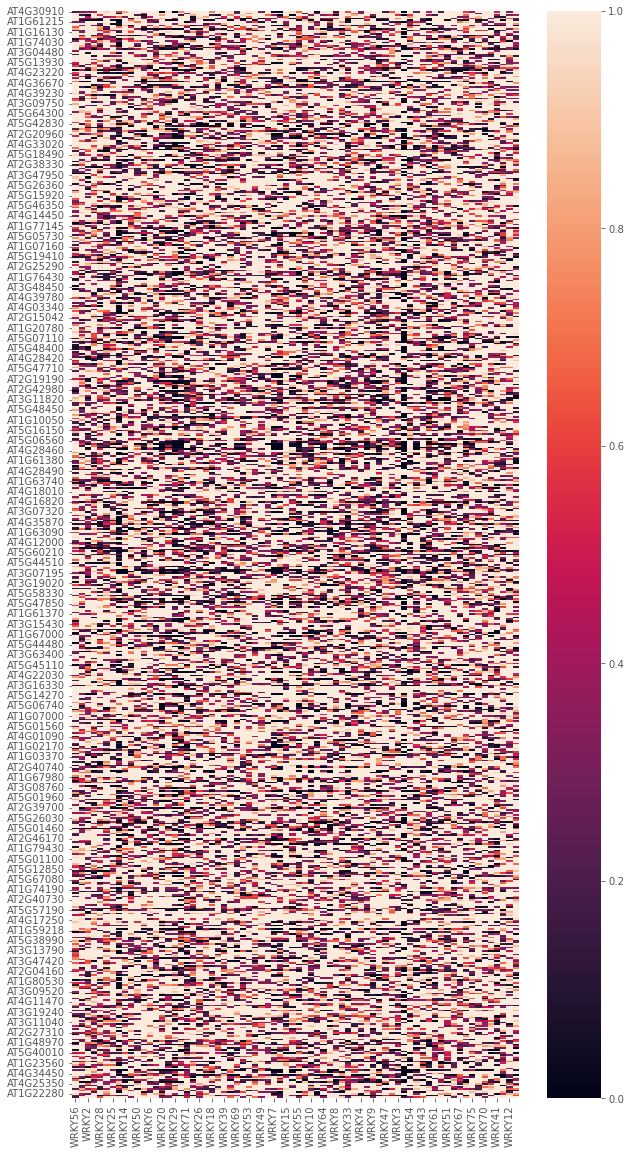

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(ab_pval_df, annot=False)